# PSIO – Laboratorium 3 (Progowanie, tło rank, kolory)
Rozwiązania zadań na podstawie `lab3/desc.txt`. Opisy i komentarze po polsku.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, data, filters, morphology, util, exposure
from skimage.filters import try_all_threshold
from skimage.morphology import disk


# Pomocnicze funkcje
def to_gray_u8(img):
    if img.ndim == 3:
        img = color.rgb2gray(img)
    if img.dtype == np.uint8:
        return img
    img = np.clip(img, 0, 1)
    return (img * 255).astype(np.uint8)


def show_with_hist(img_u8, title, t=None):
    h, _ = np.histogram(img_u8.ravel(), bins=256, range=(0, 256))
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    ax[0].imshow(img_u8, cmap='gray')
    ax[0].set_title(title)
    ax[0].axis('off')
    ax[1].plot(h, color='black')
    ax[1].set_title('Histogram 256 kubełków')
    ax[1].set_xlim(0, 255)
    if t is not None: ax[1].axvline(t, color='red', linestyle='--', label=f't={t}')
    if t is not None: ax[1].legend()
    plt.tight_layout()
    plt.show()


def bin_show(img_u8, t, title):
    bin_img = (img_u8 > t).astype(np.uint8) * 255
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    ax[0].imshow(bin_img, cmap='gray')
    ax[0].set_title(f'Progowanie > {t}')
    ax[0].axis('off')
    h, _ = np.histogram(img_u8.ravel(), bins=256, range=(0, 256))
    ax[1].plot(h, color='black')
    ax[1].axvline(t, color='red', linestyle='--')
    ax[1].set_title('Histogram z zaznaczonym progiem')
    ax[1].set_xlim(0, 255)
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


def safe_read(paths):
    for p in paths:
        try:
            return io.imread(p)
        except Exception:
            pass
    raise FileNotFoundError(paths)


## Zadanie 1 – try_all_threshold na `gears1.png`

In [ ]:
# Wczytaj i konwertuj do skali szarości [0..255]
img_color = safe_read(['lab3/gears1.png', 'gears1.png'])
img_u8 = to_gray_u8(img_color)
show_with_hist(img_u8, 'gears1 – odcienie szarości')

# Podgląd wszystkich metod progowania
fig, ax = try_all_threshold(img_u8, verbose=False, figsize=(12, 8))
plt.show()

# Wybór dwóch metod (możesz zmienić po inspekcji figur). Często: Otsu i Yen
t_otsu = filters.threshold_otsu(img_u8)
t_yen = filters.threshold_yen(img_u8)
bin_show(img_u8, int(t_otsu), 'gears1 – Otsu')
bin_show(img_u8, int(t_yen), 'gears1 – Yen')

## Zadanie 2 – tekst: tło rank.maximum, odejmowanie i progowanie

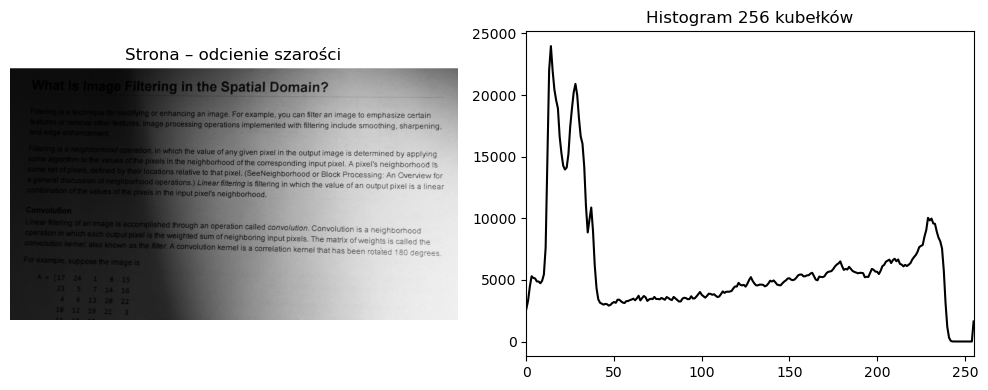

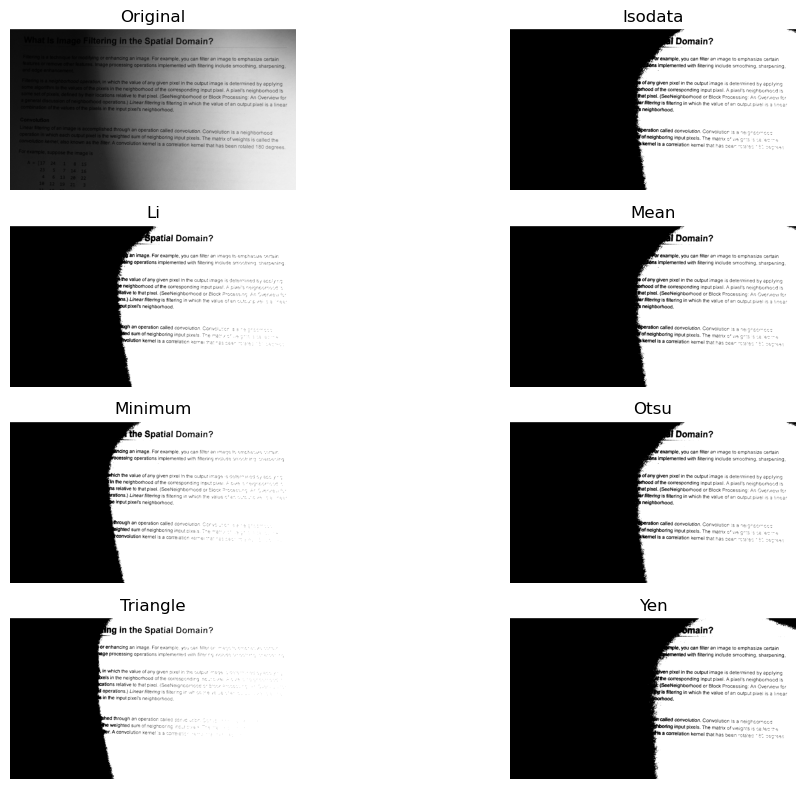

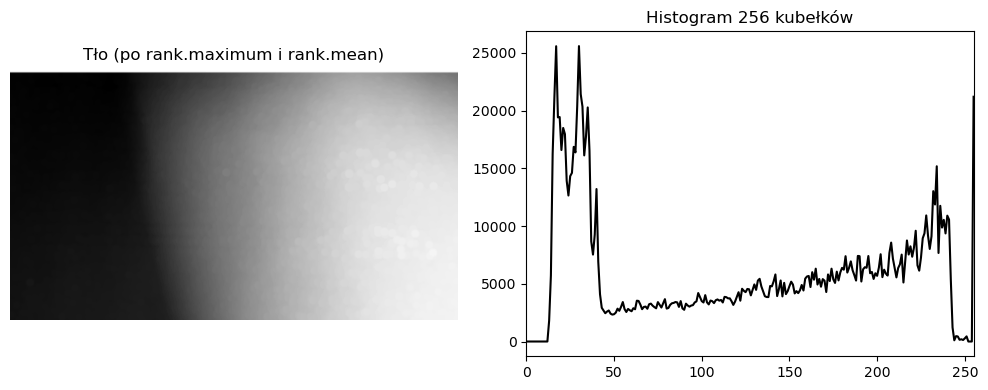

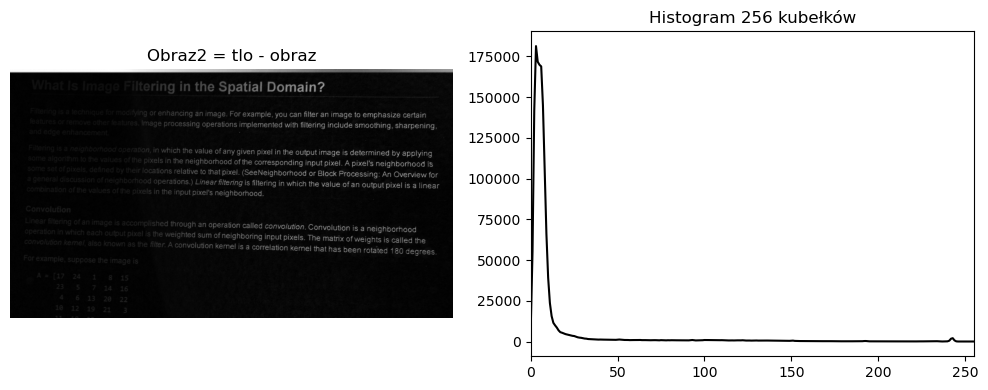

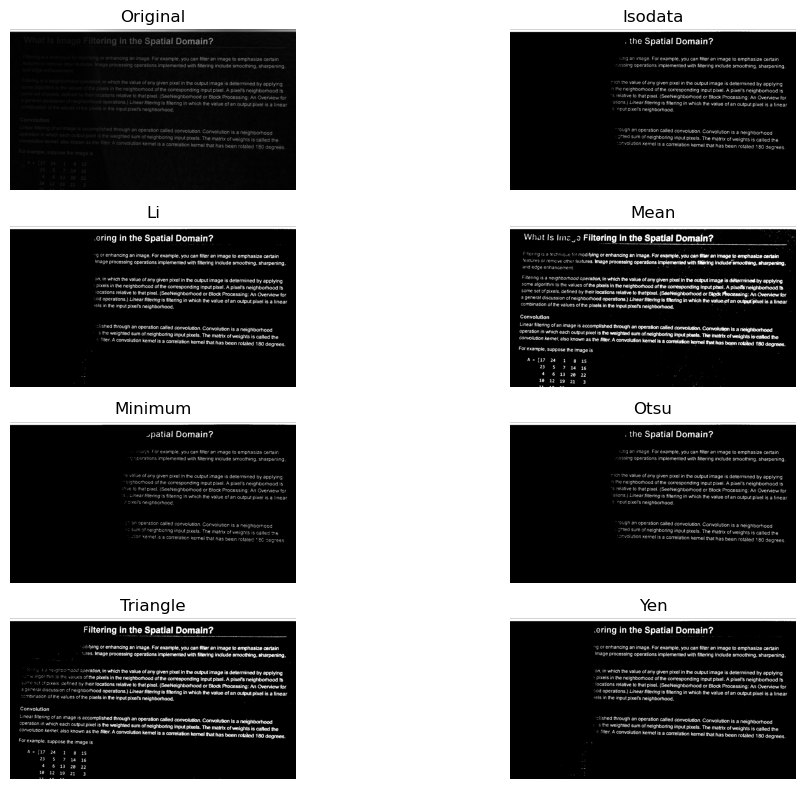

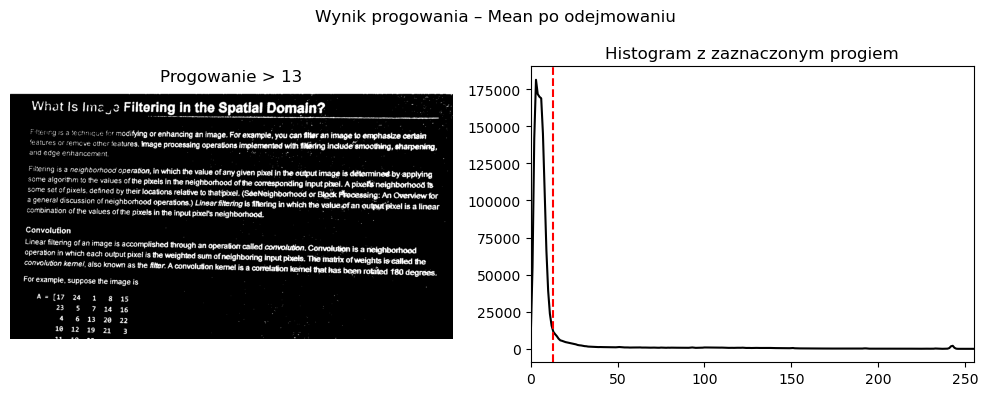

Zapisano wynik do lab3_printed_text_binary.png


In [19]:
page = safe_read(['printed_text.png'])

page_u8 = to_gray_u8(page)
show_with_hist(page_u8, 'Strona – odcienie szarości')

# Szybkie sprawdzenie metod progowania
fig, ax = try_all_threshold(page_u8, verbose=False, figsize=(12, 8))
plt.show()

# Szacowanie tła filtrem rank.maximum (uint8, wymagany selem)
se = disk(15)  # można zwiększyć dla bardziej rozmytego tła
tlo = filters.rank.maximum(page_u8, footprint=se)
# Wygładzanie tła przed odejmowaniem (opcjonalnie)
tlo_mean = filters.rank.mean(tlo, footprint=disk(3))

# Odejmowanie: tlo - obraz
obraz2 = util.img_as_ubyte(np.clip((tlo_mean.astype(np.int16) - page_u8.astype(np.int16)), 0, 255) / 255.0)
show_with_hist(tlo_mean, 'Tło (po rank.maximum i rank.mean)')
show_with_hist(obraz2, 'Obraz2 = tlo - obraz')

# Dobór progu po odejmowaniu
fig, ax = try_all_threshold(obraz2, verbose=False, figsize=(12, 8))
plt.show()
t_best = filters.threshold_mean(obraz2)
bin_show(obraz2, int(t_best), 'Wynik progowania – Mean po odejmowaniu')

# Zapis wyniku na dysk (dla pełnej rozdzielczości)
result = (obraz2 > t_best).astype(np.uint8) * 255
io.imsave('lab3_printed_text_binary.png', result)
print('Zapisano wynik do lab3_printed_text_binary.png')

## Zadanie 3 – blood_smear: dwa progi i obraz barwny

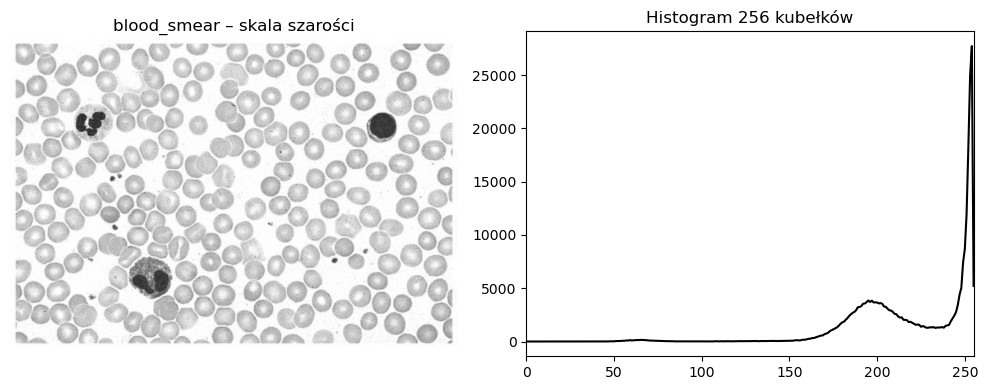

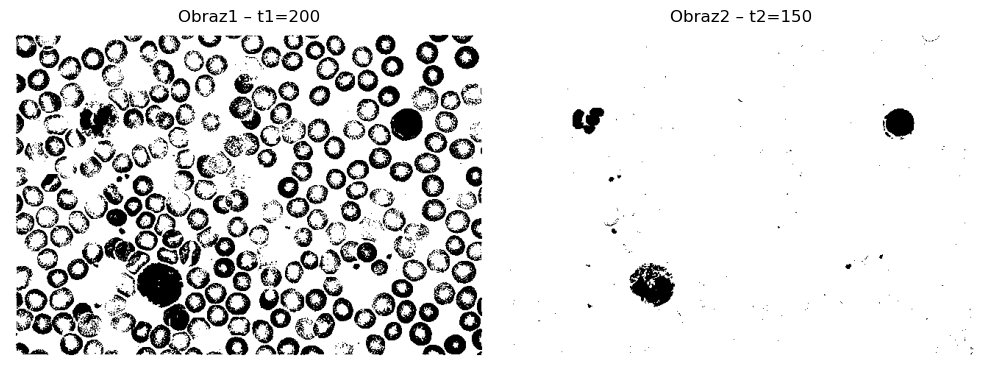

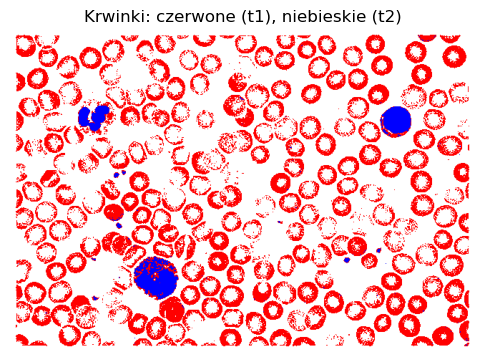

In [42]:

blood = safe_read(['blood_smear.jpg'])

blood_gray = to_gray_u8(blood)
show_with_hist(blood_gray, 'blood_smear – skala szarości')

t1 = 200
t2 = 150
img1 = (blood_gray > t1).astype(np.uint8) * 255
img2 = (blood_gray > t2).astype(np.uint8) * 255
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].imshow(img1, cmap='gray')
ax[0].set_title(f'Obraz1 – t1={t1}')
ax[0].axis('off')
ax[1].imshow(img2, cmap='gray')
ax[1].set_title(f'Obraz2 – t2={t2}')
ax[1].axis('off')
plt.tight_layout()
plt.show()

# Maska z zaznaczeniem klas (bez tła)
H, W = blood_gray.shape
overlay = np.full((H, W, 3), 255, dtype=np.uint8)

t_lo = min(t1, t2)
t_hi = max(t1, t2)
mask2 = blood_gray < t_lo
mask1 = (blood_gray >= t_lo) & (blood_gray < t_hi)
R = overlay[..., 0]
G = overlay[..., 1]
B = overlay[..., 2]
R[mask1] = 255
G[mask1] = 0
B[mask1] = 0
R[mask2] = 0
G[mask2] = 0
B[mask2] = 255
plt.figure(figsize=(6, 6))
plt.imshow(overlay)
plt.title('Krwinki: czerwone (t1), niebieskie (t2)')
plt.axis('off')
plt.show()


### (Dodatkowe) – detekcja na podstawie koloru (niebo → airbus)

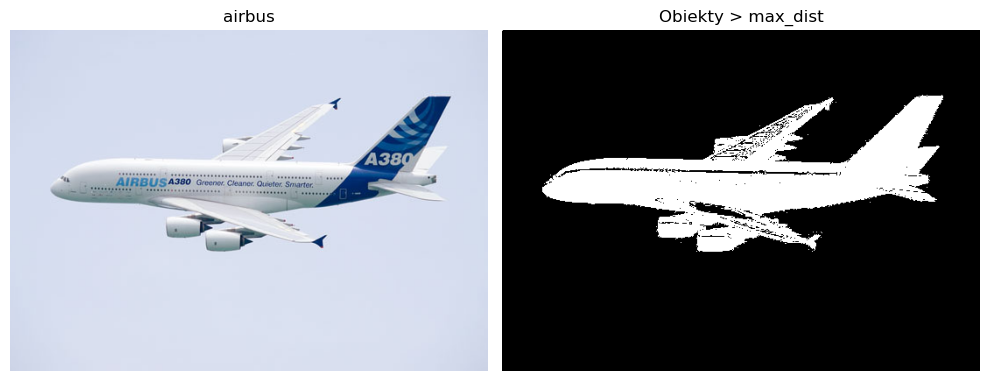

In [44]:
plane_path = ['airbus.png']

plane = safe_read(plane_path)

plane_u8 = util.img_as_ubyte(plane if plane.dtype != np.uint8 else plane)

# Szacowanie koloru nieba z górnego pasa obrazu (robust)
H, W = plane_u8.shape[:2]
samp_h = max(10, H // 6)
sky_band = plane_u8[:samp_h, :, :].astype(np.float32)
mean_rgb = np.array([np.average(sky_band[..., i]) for i in range(3)], dtype=np.float32)
diff_sky = np.linalg.norm(sky_band - mean_rgb, axis=-1)
thr = float(np.percentile(diff_sky, 99)) + 5.0

# Segmentacja samolotu względem koloru nieba
diff_all = np.linalg.norm(plane_u8.astype(np.float32) - mean_rgb, axis=-1)
mask = (diff_all > thr).astype(np.uint8) * 255
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].imshow(plane_u8)
ax[0].set_title('airbus')
ax[0].axis('off')
ax[1].imshow(mask, cmap='gray')
ax[1].set_title('Obiekty > max_dist')
ax[1].axis('off')
plt.tight_layout()
plt.show()